教授にプレゼン後、データの保存をし、テーブルとして値を持つ必要があることがわかった
大きなデータになるので保存方法を考慮する必要があった。
CSV、Excel、バイナリ、HDF5が候補として挙がった。
HDF5形式は大容量のデータセットを効率的に保存するためのファイル形式であるため、採択。
参考サイトの少なさから一時的にSQLを採択
SQLをテストし、全語句のデータの保存をしてみた
SQLでは、VisualStudioCodeの拡張機能が使いづらく、SQLite3に変更した
SQLite->dataframe->変更->dataframe->変更を保存->SQLiteの完成
上記の方法では変更件数に関わらず、全件で1分30秒かかる。
変更に時間がかかりすぎな点が課題であるため、データの更新方法を検討
SQLからPythonに値を渡さず、直接書き込むことで一件当たり0.1秒以内
拡散ネットワークを作るために、その基盤となるデータセットをSQLに保存
拡散ネットワークに対し、類似度の高いものを想起する事からそれらを加点するため拡散数を３と仮定し拡散
また、拡散ネットワークを作るために、関連文字列に拡散し、ループ一回を拡散と見なしたとき、一回目の入力を除き、n=3の時,3,9,27のように、3^(n-1)のように増えていく。
また実行時間は、0.7,0.8,0.8,4.0,5.9,15.9となっており、線形的に増えている
プログラム自体の計算量はO(N^2)になっている。
拡散した値を仮に0.3として全部をSQLに書き込む処理を追加→成功
SQLから元の値を取得し、Scoreを加算していくことで活性値を表現
活性値が閾値を超えたらループが止まるようにしたいが、5以上の数値は計算上現実的ではない
活性値を超えたら。という考え方自体が並列処理でないため、同時に超えるはずが計算の手順により結果がランダムに決まってしまうことに気づいた。
そのため、理論上下記の仕様に変更する必要がある
活性値を超えたら→活性回数の上限回数を決め、最大の活性値を活性化とする。
活性化の状態を棒グラフに出力していく

In [1]:
import os
import datetime
# Get current time
current_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Create output folder with the current time as part of the name
folder_name = f"./Output_{current_time}"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [2]:
# 入力
input_str = input("Please enter string in SAPNet===>")
model_file_path = '../../KITERETU/gw2v160.model'

# 出力
database_path = folder_name + '/database.sqlite'
Heatmap_path = folder_name + '/heatmap.png'
Network_path = folder_name + '/network.png'
GIF_path = folder_name + '/graph.gif'

In [3]:
import pandas as pd
from gensim.models import Word2Vec
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 学習済みモデルのロード
model = Word2Vec.load(model_file_path)

In [4]:
from gensim.models import Word2Vec
import sqlite3


# データベースに接続し、カーソルを作成する
conn = sqlite3.connect(database_path)
cursor = conn.cursor()

# テーブルが存在しない場合のみ作成する
cursor.execute('''CREATE TABLE IF NOT EXISTS words (word TEXT, value REAL)''')

# モデル内のすべての単語と値をデータベースに保存する
for word in model.wv.key_to_index:
    cursor.execute('''INSERT INTO words VALUES (?, ?)''', (word, 0.000000))

# コミットして変更を確定する
conn.commit()

# データベース接続を閉じる
conn.close()


In [5]:
# モデル内に登録されている単語リストの長さをlen関数で見る（＝単語数）
print(len(model.wv.key_to_index))

# 「群馬」に似ている単語TOP7を書き出す
out = model.wv.most_similar(positive=[input_str], topn=10)
print(out)

293753
[('神々', 0.7986013293266296), ('悪神', 0.6962325572967529), ('蛇神', 0.6953033804893494), ('化身', 0.694190502166748), ('男神', 0.6851721405982971), ('火神', 0.6847900152206421), ('聖', 0.6802096366882324), ('女神', 0.6715968251228333), ('天', 0.6702406406402588), ('アフラ・マズダー', 0.6696598529815674)]


In [6]:
print(out)

#AtCoderでよく使う辞書処理を使って県と数値を取り出す
pre=[]
pre.append(input_str)
for prefecture, value in out:
    print(prefecture, value)
    pre.append(prefecture)

[('神々', 0.7986013293266296), ('悪神', 0.6962325572967529), ('蛇神', 0.6953033804893494), ('化身', 0.694190502166748), ('男神', 0.6851721405982971), ('火神', 0.6847900152206421), ('聖', 0.6802096366882324), ('女神', 0.6715968251228333), ('天', 0.6702406406402588), ('アフラ・マズダー', 0.6696598529815674)]
神々 0.7986013293266296
悪神 0.6962325572967529
蛇神 0.6953033804893494
化身 0.694190502166748
男神 0.6851721405982971
火神 0.6847900152206421
聖 0.6802096366882324
女神 0.6715968251228333
天 0.6702406406402588
アフラ・マズダー 0.6696598529815674


In [7]:
import pandas as pd

df = pd.crosstab(pre, pre, rownames=['X'], colnames=['Y'])
df

Y,アフラ・マズダー,化身,天,女神,悪神,火神,男神,神,神々,聖,蛇神
X,,,,,,,,,,,
アフラ・マズダー,1,0,0,0,0,0,0,0,0,0,0
化身,0,1,0,0,0,0,0,0,0,0,0
天,0,0,1,0,0,0,0,0,0,0,0
女神,0,0,0,1,0,0,0,0,0,0,0
悪神,0,0,0,0,1,0,0,0,0,0,0
火神,0,0,0,0,0,1,0,0,0,0,0
男神,0,0,0,0,0,0,1,0,0,0,0
神,0,0,0,0,0,0,0,1,0,0,0
神々,0,0,0,0,0,0,0,0,1,0,0


In [8]:
for i in pre:
    for j in pre:
        #0を除外する処理を入れていないので計算数がその分多い
        if model.wv.similarity(i,j) >= 1.0:
            df.loc[i,j]=0.0
        elif model.wv.similarity(i,j) >= 0.6:
            df.loc[i,j]=model.wv.similarity(i,j)
        else:
            df.loc[i,j]=0
        #print(df.loc['Bob', 'age'])
        #df.iloc[1,0]
df

Y,アフラ・マズダー,化身,天,女神,悪神,火神,男神,神,神々,聖,蛇神
X,,,,,,,,,,,
アフラ・マズダー,0.000000,0.000000,0.000000,0.000000,0.732714,0.623921,0.000000,0.669660,0.675584,0.000000,0.000000
化身,0.000000,0.000000,0.000000,0.000000,0.676826,0.000000,0.611755,0.694190,0.000000,0.000000,0.708787
天,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.670241,0.000000,0.601042,0.000000
女神,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.629511,0.671597,0.707747,0.000000,0.000000
悪神,0.732714,0.676826,0.000000,0.000000,0.000000,0.716010,0.000000,0.696233,0.666967,0.000000,0.700410
火神,0.623921,0.000000,0.000000,0.000000,0.716010,0.000000,0.641001,0.684790,0.670650,0.000000,0.648209
男神,0.000000,0.611755,0.000000,0.629511,0.000000,0.641001,0.000000,0.685172,0.000000,0.000000,0.631930
神,0.669660,0.694190,0.670241,0.671597,0.696233,0.684790,0.685172,0.000000,0.798601,0.680210,0.695303
神々,0.675584,0.000000,0.000000,0.707747,0.666967,0.670650,0.000000,0.798601,0.000000,0.000000,0.617292


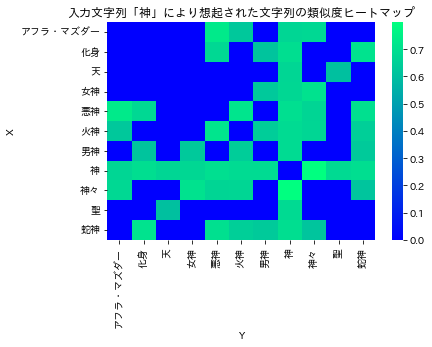

In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib


plt.figure()
plt.title("入力文字列「{}」により想起された文字列の類似度ヒートマップ".format(input_str))
sns.heatmap(df,cmap="winter")
plt.savefig(Heatmap_path)

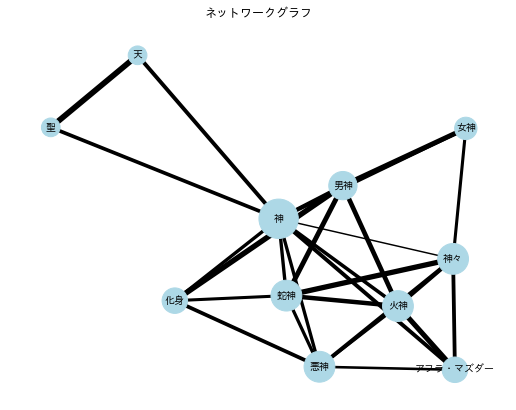

<Figure size 432x288 with 0 Axes>

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

# ネットワークグラフの作成
G = nx.from_pandas_adjacency(df, create_using=nx.Graph)

# グラフの描画
plt.figure(figsize=(len(input_str)+8, len(input_str)+6))
pos = nx.spring_layout(G)  # ノードの位置を設定
weights = nx.get_edge_attributes(G, 'weight')

# 辺の太さを重みに応じて調整
max_weight = max(weights.values())
edge_widths = [(6 * (1 - weights[edge])) ** 2 for edge in G.edges()]

# ノードの太さを重みに応じて調整
node_sizes = [50 + 150 * G.degree(node) for node in G.nodes()]

# グラフを描画
japanize_matplotlib.japanize()
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='black')
nx.draw_networkx_labels(G, pos, font_family='IPAexGothic', font_color='black', font_size=10)
plt.title('ネットワークグラフ')
plt.axis('off')
plt.show()
plt.savefig(Network_path)

In [11]:
import sqlite3 
import pandas as pd 
import sqlite3 
import matplotlib.pyplot as plt 
from PIL import Image  # Import the PIL module 
import io 
from IPython.display import HTML
from IPython.display import display
from PIL import Image # Import the PIL module 
import glob # Import the glob module

 # Connect to the database 
conn = sqlite3.connect(database_path) 
cursor = conn.cursor() 
ans = [] 
ans.append([input_str])
print(ans) 
images = [] 
for i in range(3): 
    ans.append([]) 
    for j in range(len(ans[i])): 
        out = model.wv.most_similar(positive=[ans[i][j]], topn=3) 
        for prefecture, value in out: 
            ans[i+1].append(prefecture) 
            # Execute SQL query to get the numerical value 
            cursor.execute("SELECT value FROM words WHERE word = ?", (prefecture,)) 
            result = cursor.fetchone()[0] 
            new_result = result + value 
            val = '{:6f}'.format(new_result) 
            cursor.execute("UPDATE words SET value = ? WHERE word = ?", (val, prefecture)) 
            # Execute SQL query to get the result 
            cursor.execute("SELECT word, value FROM words ORDER BY value DESC LIMIT 10") 
            results = cursor.fetchall() 
            words = [result[0] for result in results] 
            values = [result[1] for result in results] 
            print(words) 
            print(values) 
            # Create the graph 
            plt.bar(words, values)  # Display words on the x-axis 
            plt.xlabel('Word') 
            plt.ylabel('Value') 
            # Create a PIL Image object from the plot 
            buf = io.BytesIO() 
            plt.savefig(buf, format='png') 
            buf.seek(0) 
            im = Image.open(buf) 
            images.append(im) 
            plt.clf()  # Clear the figure for the next iteration 
# Save the frames as a GIF image 

images[0].save(GIF_path, format='GIF', append_images=images[1:], save_all=True, duration=1000, loop=0) 
# Commit changes and close the database connection 
conn.commit() 
conn.close() 

[['神']]
['神々', '其の', '使用', '1', '世紀', '遡る', 'こと', '出来る', '、', '5']
[0.798601, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['神々', '悪神', '其の', '使用', '1', '世紀', '遡る', 'こと', '出来る', '、']
[0.798601, 0.696233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['神々', '悪神', '蛇神', '其の', '使用', '1', '世紀', '遡る', 'こと', '出来る']
[0.798601, 0.696233, 0.695303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['神', '神々', '悪神', '蛇神', '其の', '使用', '1', '世紀', '遡る', 'こと']
[0.798601, 0.798601, 0.696233, 0.695303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['神', '神々', '女神', '悪神', '蛇神', '其の', '使用', '1', '世紀', '遡る']
[0.798601, 0.798601, 0.707747, 0.696233, 0.695303, 0.0, 0.0, 0.0, 0.0, 0.0]
['神', '神々', '女神', '天界', '悪神', '蛇神', '其の', '使用', '1', '世紀']
[0.798601, 0.798601, 0.707747, 0.705471, 0.696233, 0.695303, 0.0, 0.0, 0.0, 0.0]
['神', '神々', 'アンラ', '女神', '天界', '悪神', '蛇神', '其の', '使用', '1']
[0.798601, 0.798601, 0.744731, 0.707747, 0.705471, 0.696233, 0.695303, 0.0, 0.0, 0.0]
['神', '神々', 'アンラ', 'マンユ', '女神', '天界', '悪神', '蛇神', '其の', '使用']
[0.798601, 0.798

<Figure size 432x288 with 0 Axes>


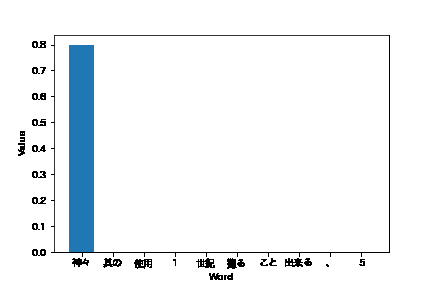

In [12]:
import base64
from IPython import display as dd # display関数と名前が被るので別名にしておきます。

with open(GIF_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode("ascii")
    
display(dd.HTML(f'<img src="data:image/gif;base64,{b64}" />'))